<a href="https://colab.research.google.com/github/GonzaloJab/image-clustering/blob/master/Time_SeriesClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [9]:
!pip install --quiet torch

In [10]:
!pip install --quiet pytorch-lightning

In [11]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

#from pytorch_lightning.metrics.functional import accuracy #Lets look for a substitute!!
import os

from sklearn.metrics import classification_report, confusion_matrix


In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 10

In [13]:
pl.seed_everything(42)



INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [14]:
x_train = pd.read_csv("/content/X_train.csv")
y_train = pd.read_csv("/content/y_train.csv")

In [15]:
x_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [16]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


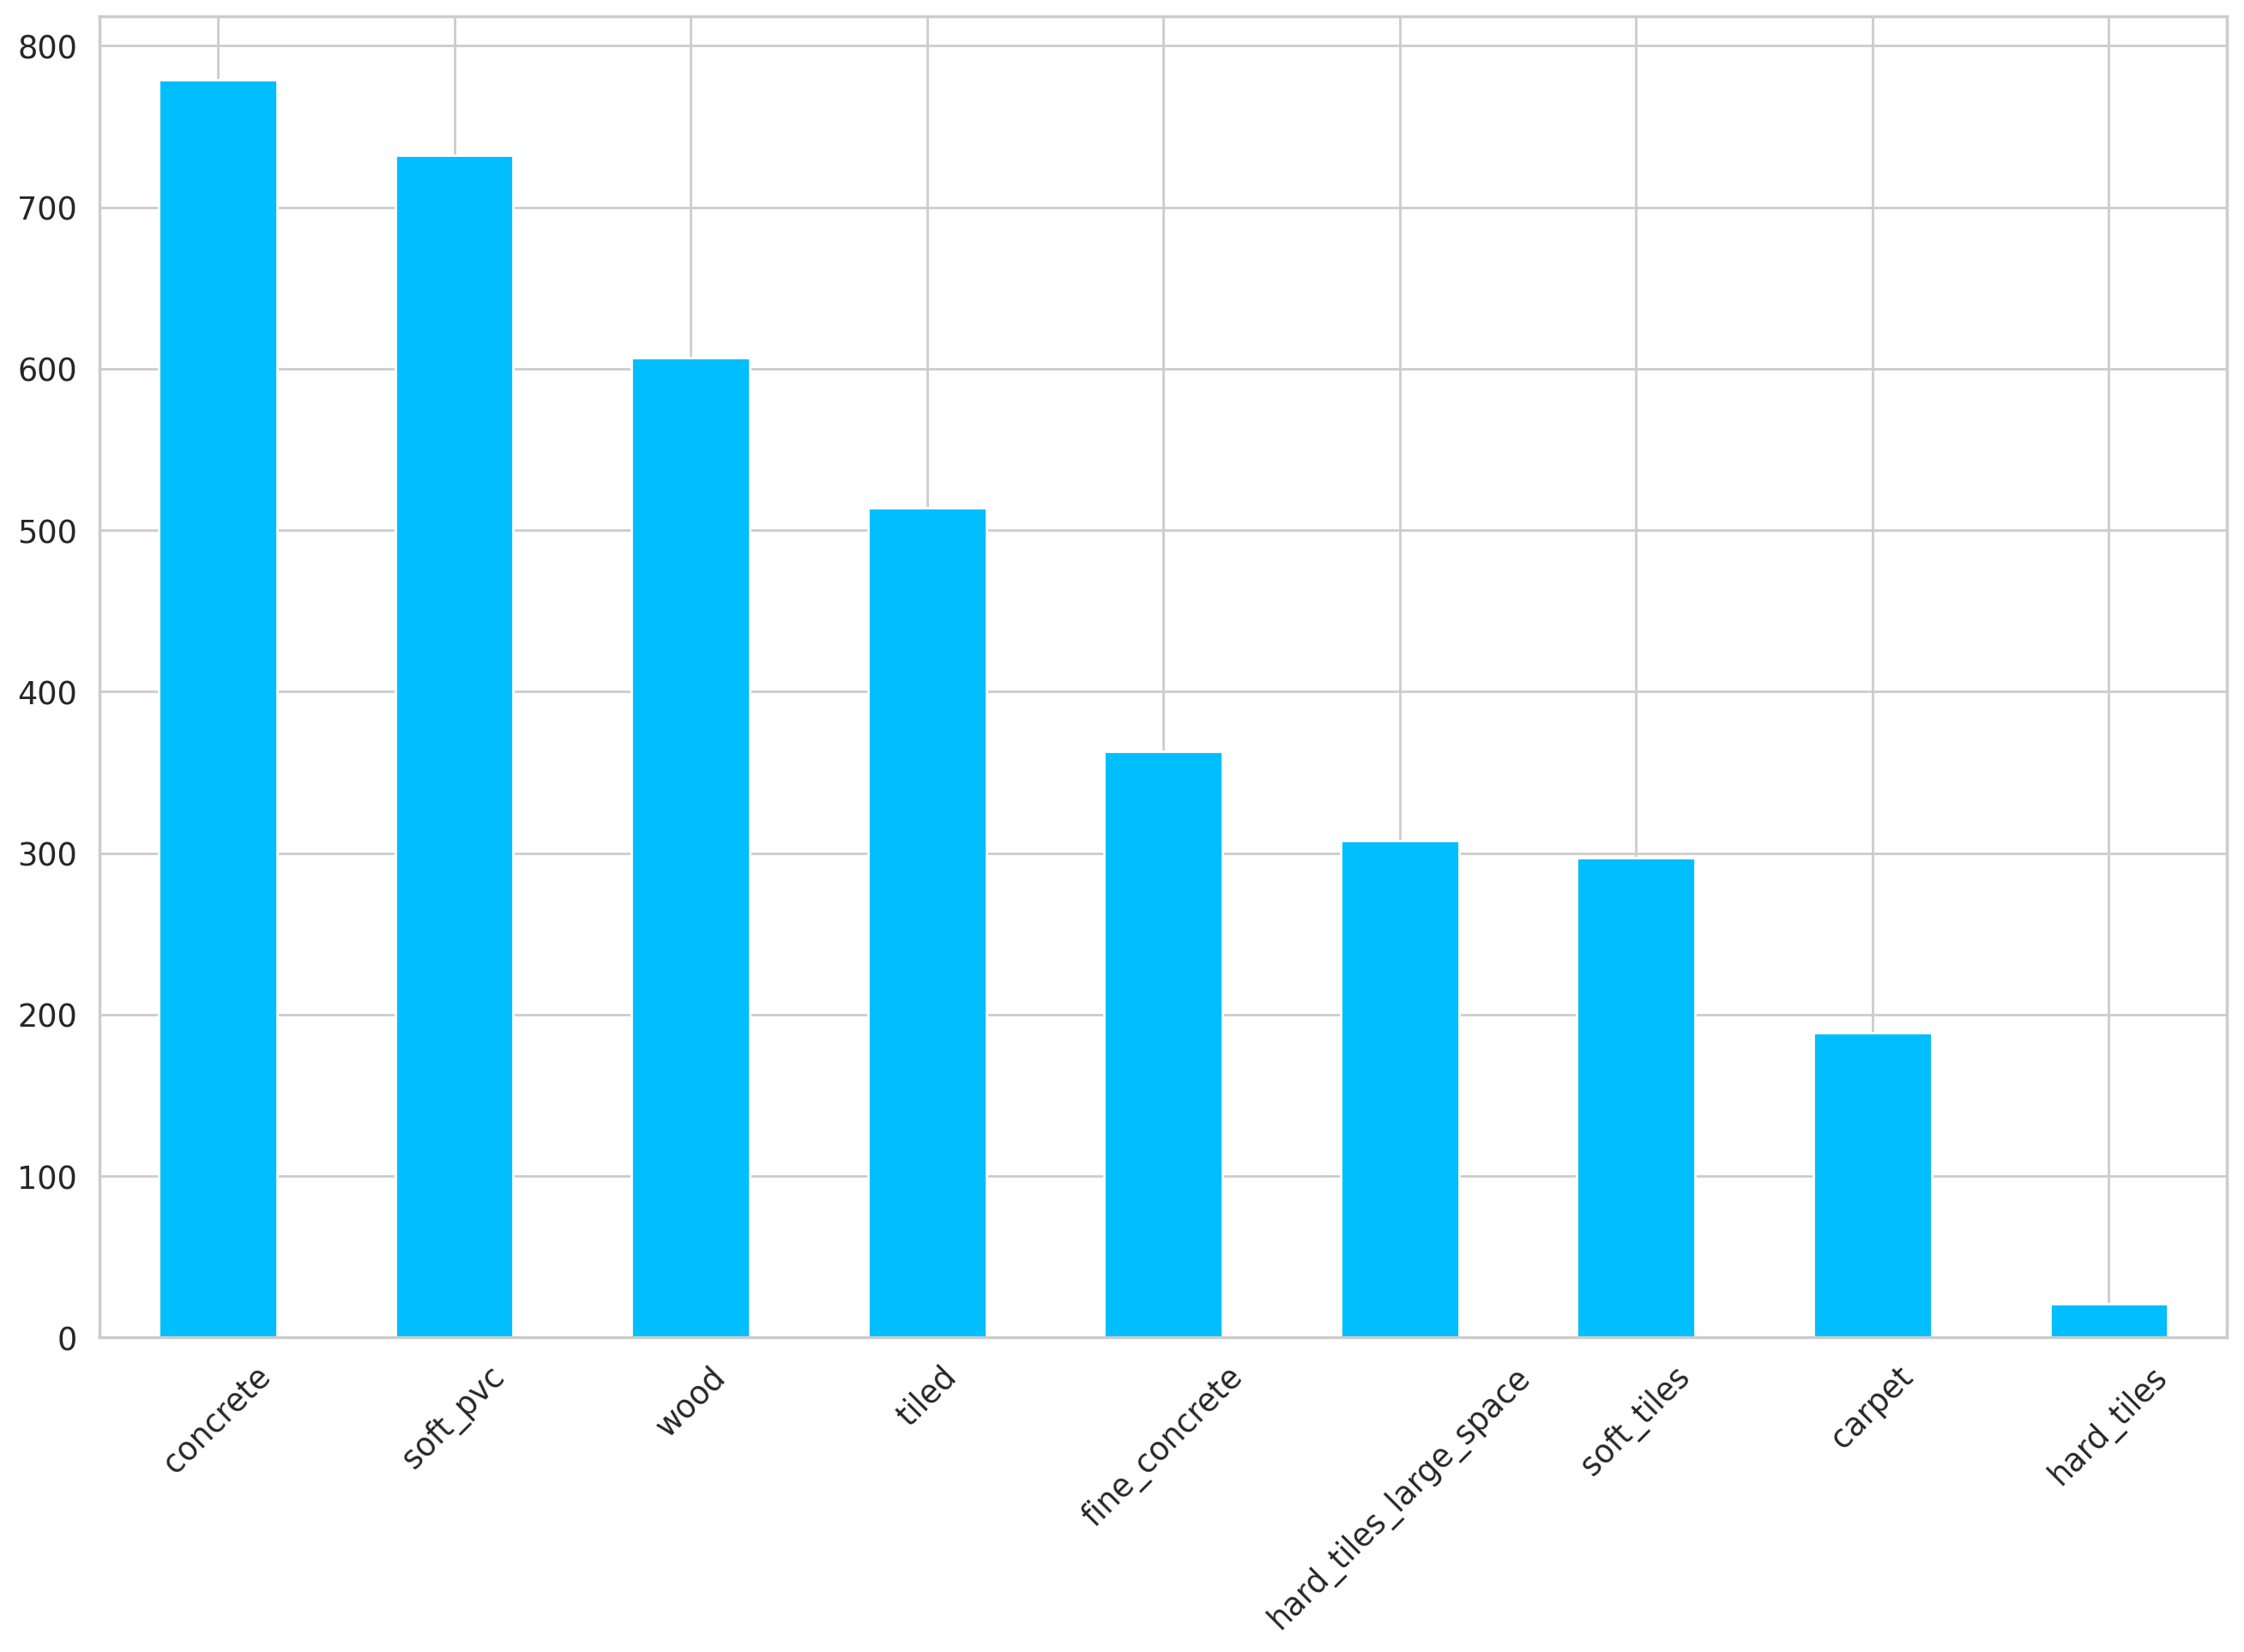

In [17]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

Preprocessing

In [18]:
label_encoder = LabelEncoder()
encoded_labels =  label_encoder.fit_transform(y_train.surface)

In [19]:
encoded_labels[:8]

array([2, 1, 1, 1, 6, 7, 5, 1])

In [20]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [21]:
label_encoder.inverse_transform([1])

array(['concrete'], dtype=object)

In [22]:
y_train["label"] = encoded_labels

In [23]:
FEATURE_COLUMNS = x_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [24]:
x_train.series_id.value_counts()

0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: series_id, Length: 3810, dtype: int64

In [25]:
(x_train.series_id.value_counts() == 128).sum() == len(y_train)

True

In [26]:
sequences = []

for series_id, group in x_train.groupby("series_id"):
  sequence_features = group[FEATURE_COLUMNS]
  label = y_train[y_train.series_id == series_id].iloc[0].label

  sequences.append((sequence_features,label))

In [27]:
train_sequences , test_sequences = train_test_split(sequences, test_size=0.2)

In [28]:
len(train_sequences), len(test_sequences)

(3048, 762)

In [29]:
class SurfaceDataset(Dataset):
  def __init__(self, sequences):
    self.sequences = sequences
  def __len__(self):
    return len(self.sequences)
  def __getitem__(self,idx):
    sequence, label = self.sequences[idx]
    return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
        label=torch.tensor(label).long()
    )

In [30]:
class SurfaceDataModule(pl.LightningDataModule):

  def __init___(self, train_sequences, test_sequences,batch_size):
    super().__init__()
    self.train_sequences = train_sequences
    self.test_sequences = test_sequences
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = SurfaceDataset(self.train_sequences)
    self.test_dataset = SurfaceDataset(self.test_sequences)

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=cpu_count()
    )
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=cpu_count()
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=cpu_count()
    )

In [31]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

TypeError: LightningDataModule.__init__() takes 1 positional argument but 4 were given

MODEL

In [ ]:
class SequenceModel(nn.Module):
  def __init__(self, n_features,n_classes, n_hidden=256,n_layers=3):
    super().__init__()

    #self.n_hidden = n_hidden

    #RETRAIN AND FIND THE BEST PARAMETERS
    self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden, #Neuros per layer
        num_layers=n_layers,
        batch_first=True,
        dropout=0.75
    )

    self.classifier = nn.Linear(n_hidden,n_classes)

  def forward(self,x):
    self.lstm.flatten_parameters()
    _, (hidden,_) = self.lstm(x)

    out = hidden[-1]
    return self.classifier(out)

In [ ]:
class SurfacePredictor(pl.LightningModule):
  def __init__(self, n_features: int, n_classes: int):
    super().__intit()
    self.model = SequenceModel(n_features, n_classes)
    self.criterion = nn.CrossEntropyLoss()
  def forward(self, x, labels=None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch. batch_idx):
    sequences = batch["sequence"]
    labels = batch["label"]
    loss, outputs = self(sequences,labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("train_loss", loss, prog_bar = True, logger=True)
    self.log("train_accuracy", step_accuracy, prog_bar = True, logger=True)
    return {"loss": loss, "accuracy": step_accuracy}

  def validation_step(self, batch. batch_idx):
    sequences = batch["sequence"]
    labels = batch["label"]
    loss, outputs = self(sequences,labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("val_loss", loss, prog_bar = True, logger=True)
    self.log("val_accuracy", step_accuracy, prog_bar = True, logger=True)
    return {"loss": loss, "accuracy": step_accuracy}

  def test_step(self, batch. batch_idx):
    sequences = batch["sequence"]
    labels = batch["label"]
    loss, outputs = self(sequences,labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("test_loss", loss, prog_bar = True, logger=True)
    self.log("test_accuracy", step_accuracy, prog_bar = True, logger=True)
    return {"loss": loss, "accuracy": step_accuracy}

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr=0..0001)



In [ ]:
model = SurfacePredictor(
    n_features=len(FEATURE_COLUMNS),
    n_classee=len(label_encoder.classes)
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs